In [ ]:
#https://github.com/quatrope/scikit-criteria/blob/master/docs/source/tutorial/quickstart.ipynb

In [2]:
import skcriteria as skc  # we use skc as an abbreviation for scikit-criteria

In [4]:
# 2 alternatives by 3 criteria
matrix = [
    [1, 2, 3],  # alternative 1
    [4, 5, 6],  # alternative 2
]
matrix

[[1, 2, 3], [4, 5, 6]]

In [5]:
# let's says the first two alternatives are
# for maximization and the last one for minimization
objectives = [max, max, min]
objectives

[<function max>, <function max>, <function min>]

In [6]:
# we use the built-in function as aliases
dm = skc.mkdm(matrix, [min, max, min])
dm

,C0[▼ 1.0],C1[▲ 1.0],C2[▼ 1.0]
A0,1,2,3
A1,4,5,6


In [7]:
dm = skc.mkdm(
    matrix,
    objectives,
    alternatives=["car 0", "car 1"],
    criteria=["autonomy", "comfort", "price"],
)
dm

,autonomy[▲ 1.0],comfort[▲ 1.0],price[▼ 1.0]
car 0,1,2,3
car 1,4,5,6


In [9]:
dm = skc.mkdm(
    matrix,
    objectives,
    weights=[0.5, 0.05, 0.45],
    alternatives=["car 0", "car 1"],
    criteria=["autonomy", "comfort", "price"],
)
dm

,autonomy[▲ 0.50],comfort[▲ 0.05],price[▼ 0.45]
car 0,1,2,3
car 1,4,5,6


In [10]:
dm.matrix  # note how this data ignores the objectives and the weights

Criteria,autonomy,comfort,price
Alternatives,,,
car 0,1,2,3
car 1,4,5,6


In [11]:
dm.objectives

autonomy    MAX
comfort     MAX
price       MIN
Name: Objectives, dtype: object

In [12]:
dm.weights

autonomy    0.50
comfort     0.05
price       0.45
Name: Weights, dtype: float64

In [13]:
dm.alternatives, dm.criteria

(_ACArray(['car 0', 'car 1'], dtype=object),
 _ACArray(['autonomy', 'comfort', 'price'], dtype=object))

In [14]:
dm = dm.copy(alternatives=["VW", "Ford"])
dm

,autonomy[▲ 0.50],comfort[▲ 0.05],price[▼ 0.45]
VW,1,2,3
Ford,4,5,6


<AxesSubplot:xlabel='Criteria', ylabel='Alternatives'>

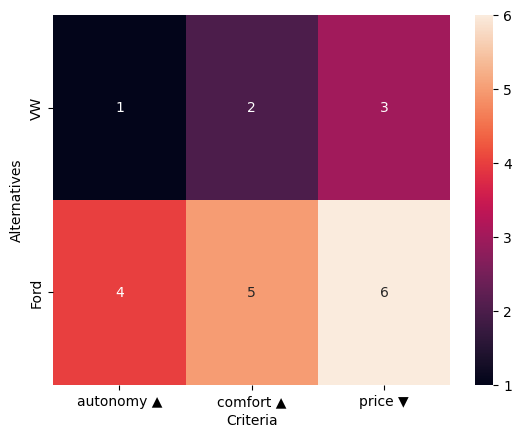

In [15]:
dm.plot()

<AxesSubplot:xlabel='Criteria'>

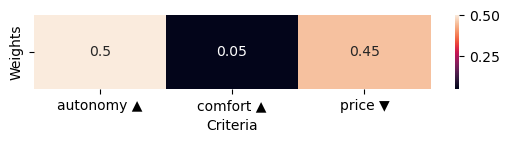

In [16]:
dm.plot.wheatmap()

<AxesSubplot:ylabel='Density'>

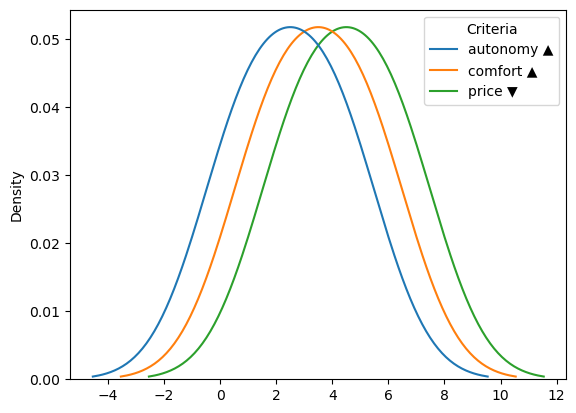

In [17]:
dm.plot("kde")

<AxesSubplot:ylabel='Density'>

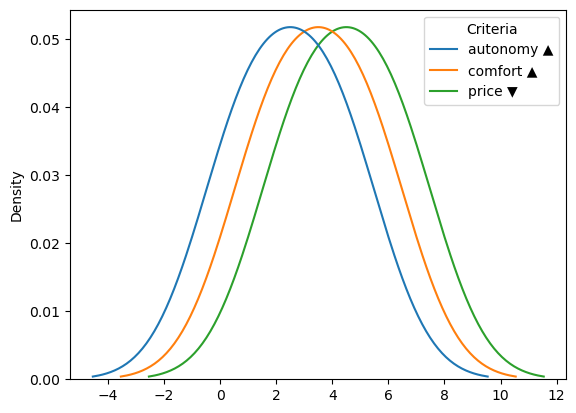

In [19]:
dm.plot.kde()

<AxesSubplot:>

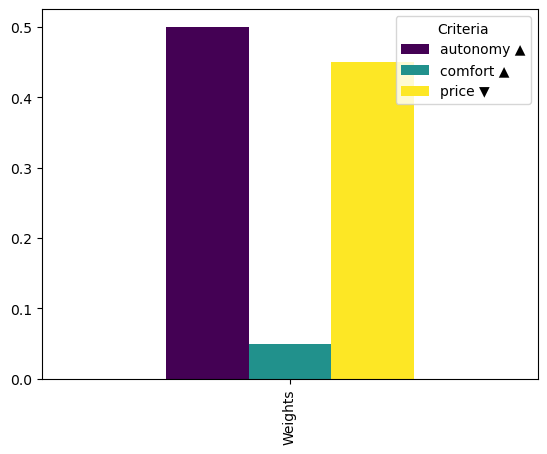

In [20]:
dm.plot.wbar(cmap="viridis")

In [21]:
from skcriteria.preprocessing import invert_objectives, scalers

In [22]:
inverter = invert_objectives.InvertMinimize()
dmt = inverter.transform(dm)
dmt

,autonomy[▲ 0.50],comfort[▲ 0.05],price[▲ 0.45]
VW,1,2,0.333333
Ford,4,5,0.166667


In [23]:
scaler = scalers.SumScaler(target="both")
dmt = scaler.transform(dmt)
dmt

,autonomy[▲ 0.50],comfort[▲ 0.05],price[▲ 0.45]
VW,0.2,0.285714,0.666667
Ford,0.8,0.714286,0.333333


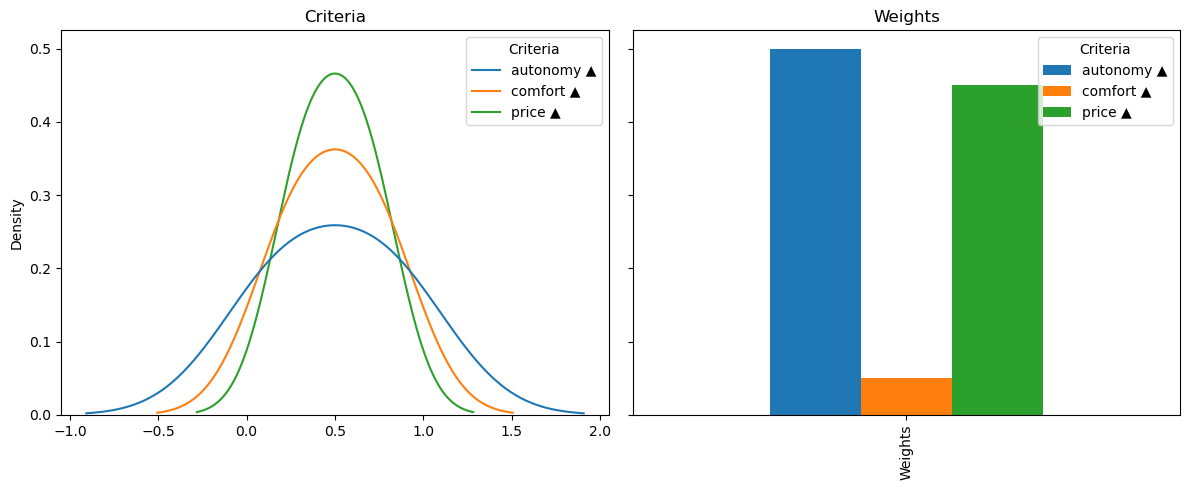

In [24]:
# we are going to user matplotlib capabilities of creat multiple figures
import matplotlib.pyplot as plt

# we create 2 axis with the same y axis
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# in the first axis we plot the criteria KDE
dmt.plot.kde(ax=axs[0])
axs[0].set_title("Criteria")


# in the second axis we plot the weights as bars
dmt.plot.wbar(ax=axs[1])
axs[1].set_title("Weights")

# adjust the layout of the figute based on the content
fig.tight_layout()

In [25]:
from skcriteria.madm import simple

In [26]:
dec = simple.WeightedSumModel()
rank = dec.evaluate(dmt)  # we use the tansformed version of the data
rank

Alternatives,VW,Ford
Rank,2,1


In [27]:
rank.e_

<extra {'score'}>

In [28]:
rank.e_.score

array([0.41428571, 0.58571429])

In [29]:
rank.rank_

array([2, 1])

In [30]:
rank.alternatives

array(['VW', 'Ford'], dtype=object)

In [31]:
rank.method

'WeightedSumModel'

In [32]:
from skcriteria.madm import similarity  # here lives TOPSIS
from skcriteria.pipeline import mkpipe  # this function is for create pipelines

In [33]:
pipe = mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),  # this scaler transform the matrix
    scalers.SumScaler(target="weights"),  # and this transform the weights
    similarity.TOPSIS(),
)

pipe

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('vectorscaler', <VectorScaler [target='matrix']>), ('sumscaler', <SumScaler [target='weights']>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [34]:
rank = pipe.evaluate(dm)
rank

Alternatives,VW,Ford
Rank,2,1


In [35]:
print(rank.e_)
print("Ideal:", rank.e_.ideal)
print("Anti-Ideal:", rank.e_.anti_ideal)
print("Similarity index:", rank.e_.similarity)

<extra {'anti_ideal', 'similarity', 'ideal'}>
Ideal: [ 0.48507125  0.04642383 -0.20124612]
Anti-Ideal: [ 0.12126781  0.01856953 -0.40249224]
Similarity index: [0.35548671 0.64451329]


In [36]:
from skcriteria.madm import electre


pipe_vector = mkpipe(
    invert_objectives.InvertMinimize(),
    scalers.VectorScaler(target="matrix"),  # this scaler transform the matrix
    scalers.SumScaler(target="weights"),  # and this transform the weights
    electre.ELECTRE1(p=0.65, q=0.35),
)

pipe_sum = mkpipe(
    invert_objectives.InvertMinimize(),
    scalers.SumScaler(target="weights"),  # transform the matrix and weights
    electre.ELECTRE1(p=0.65, q=0.35),
)

In [37]:
kernel_vector = pipe_vector.evaluate(dm)
kernel_vector

Alternatives,VW,Ford
Kernel,True,True


In [38]:
kernel_sum = pipe_sum.evaluate(dm)
kernel_sum

Alternatives,VW,Ford
Kernel,True,True


In [40]:
from skcriteria.cmp import RanksComparator, mkrank_cmp

In [41]:
import skcriteria as skc

dm = skc.datasets.load_van2021evaluation(windows_size=7)
dm

,xRV[▲ 1.0],sRV[▼ 1.0],xVV[▲ 1.0],sVV[▼ 1.0],xR2[▲ 1.0],xm[▲ 1.0]
ADA,0.029,0.156,8.144000e+09,1.586000e+10,0.312,1.821000e-11
BNB,0.033,0.167,6.141000e+09,1.118000e+10,0.396,9.167000e-09
BTC,0.015,0.097,2.095000e+11,1.388000e+11,0.281,1.254000e-08
DOGE,0.057,0.399,8.287000e+09,2.726000e+10,0.327,1.459000e-12
ETH,0.023,0.127,1.000000e+11,8.054000e+10,0.313,1.737000e-09
LINK,0.040,0.179,6.707000e+09,1.665000e+10,0.319,1.582000e-09
LTC,0.015,0.134,2.513000e+10,1.731000e+10,0.320,1.816000e-09
XLM,0.013,0.176,4.157000e+09,5.469000e+09,0.321,1.876000e-11
XRP,0.014,0.164,2.308000e+10,2.924000e+10,0.322,7.996000e-12


In [42]:
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.invert_objectives import (
    InvertMinimize,
    NegateMinimize,
)
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.madm.simple import WeightedProductModel, WeightedSumModel
from skcriteria.madm.similarity import TOPSIS

ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedSumModel(),
)

wp_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedProductModel(),
)

tp_pipe = mkpipe(
    NegateMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS(),
)

In [43]:
wsum_result = ws_pipe.evaluate(dm)
wprod_result = wp_pipe.evaluate(dm)
tp_result = tp_pipe.evaluate(dm)

display(wsum_result, wprod_result, tp_result)

Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,8,2,1,7,3,5,6,4,9


Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,6,2,1,9,3,5,4,7,8


Alternatives,ADA,BNB,BTC,DOGE,ETH,LINK,LTC,XLM,XRP
Rank,6,2,1,8,5,3,4,7,9


In [44]:
RanksComparator([("ts", tp_result), ("ws", wsum_result), ("wp", wprod_result)])

<RanksComparator [ranks=['ts', 'ws', 'wp']]>

In [45]:
rcmp = mkrank_cmp(tp_result, wsum_result, wprod_result)
rcmp

<RanksComparator [ranks=['TOPSIS', 'WeightedSumModel', 'WeightedProductModel']]>

In [46]:
rcmp.corr()  # by default the pearson correlation is used

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.783333,0.916667
WeightedSumModel,0.783333,1.000000,0.816667
WeightedProductModel,0.916667,0.816667,1.000000


In [47]:
rcmp.corr(method="kendall")  # or we can use the kendal correlation

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.666667,0.777778
WeightedSumModel,0.666667,1.000000,0.666667
WeightedProductModel,0.777778,0.666667,1.000000


In [48]:
rcmp.cov()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,7.500,5.875,6.875
WeightedSumModel,5.875,7.500,6.125
WeightedProductModel,6.875,6.125,7.500


In [49]:
rcmp.r2_score()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,1.000000,0.566667,0.833333
WeightedSumModel,0.566667,1.000000,0.633333
WeightedProductModel,0.833333,0.633333,1.000000


In [50]:
rcmp.distance()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.000000,0.666667,0.444444
WeightedSumModel,0.666667,0.000000,0.555556
WeightedProductModel,0.444444,0.555556,0.000000


In [51]:
rcmp.distance(metric="cityblock")

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.0,12.0,6.0
WeightedSumModel,12.0,0.0,10.0
WeightedProductModel,6.0,10.0,0.0


In [53]:
def my_distance(u,v,w=None):
    return 42

rcmp.distance(metric=my_distance)

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Method,,,
TOPSIS,0.0,42.0,42.0
WeightedSumModel,42.0,0.0,42.0
WeightedProductModel,42.0,42.0,0.0


In [54]:
rcmp.to_dataframe()

Method,TOPSIS,WeightedSumModel,WeightedProductModel
Alternatives,,,
ADA,6,8,6
BNB,2,2,2
BTC,1,1,1
DOGE,8,7,9
ETH,5,3,3
LINK,3,5,5
LTC,4,6,4
XLM,7,4,7
XRP,9,9,8


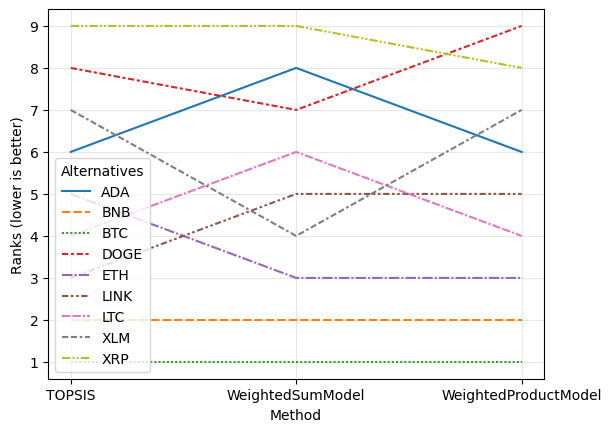

In [55]:
rcmp.plot.flow();

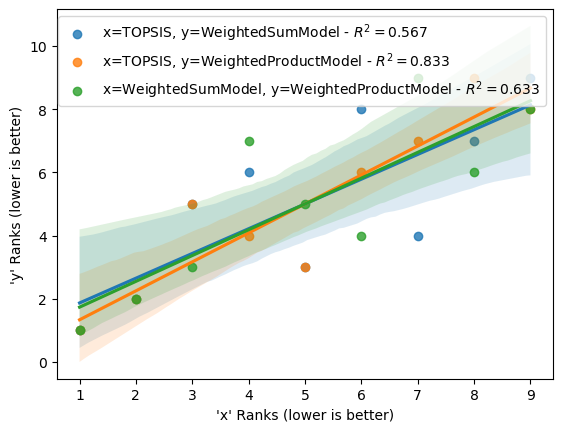

In [56]:
rcmp.plot.reg(r2=True, r2_fmt=".3f");

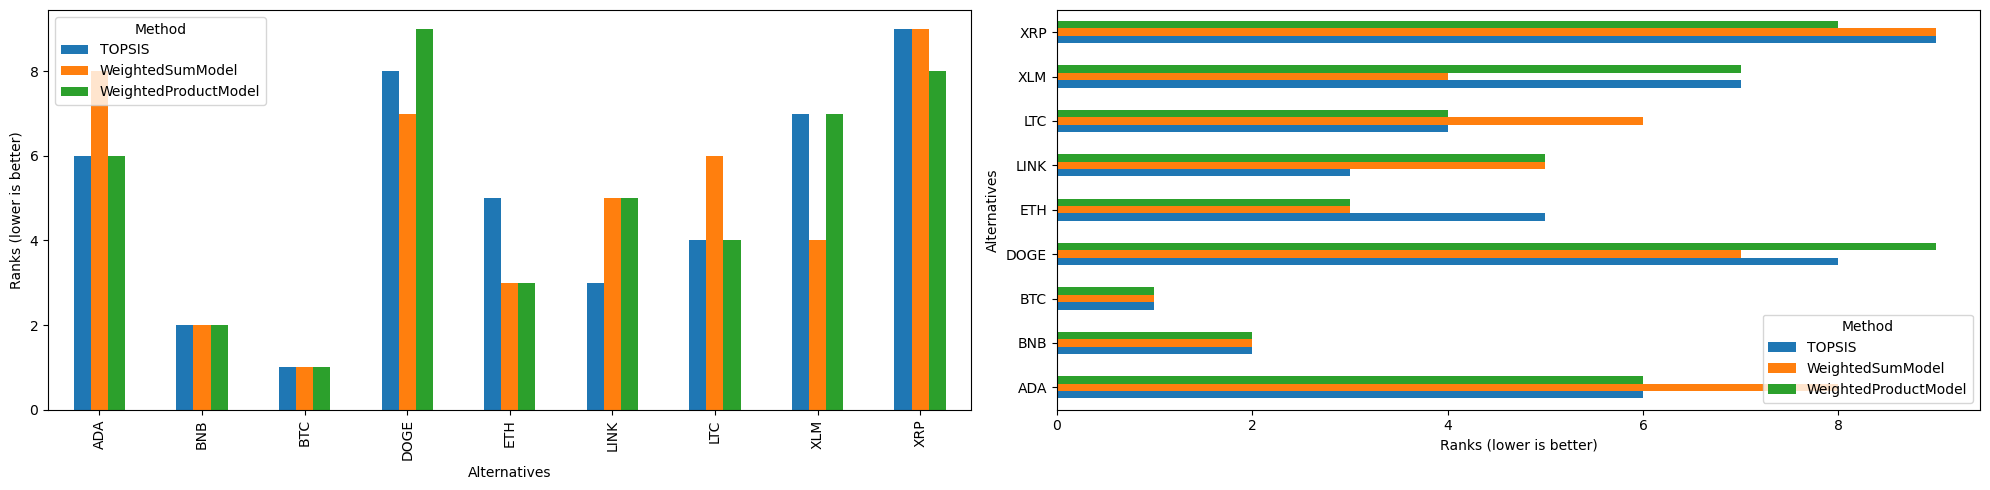

In [57]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.bar(ax=axs[0]) 
rcmp.plot.barh(ax=axs[1]) 

fig.tight_layout();

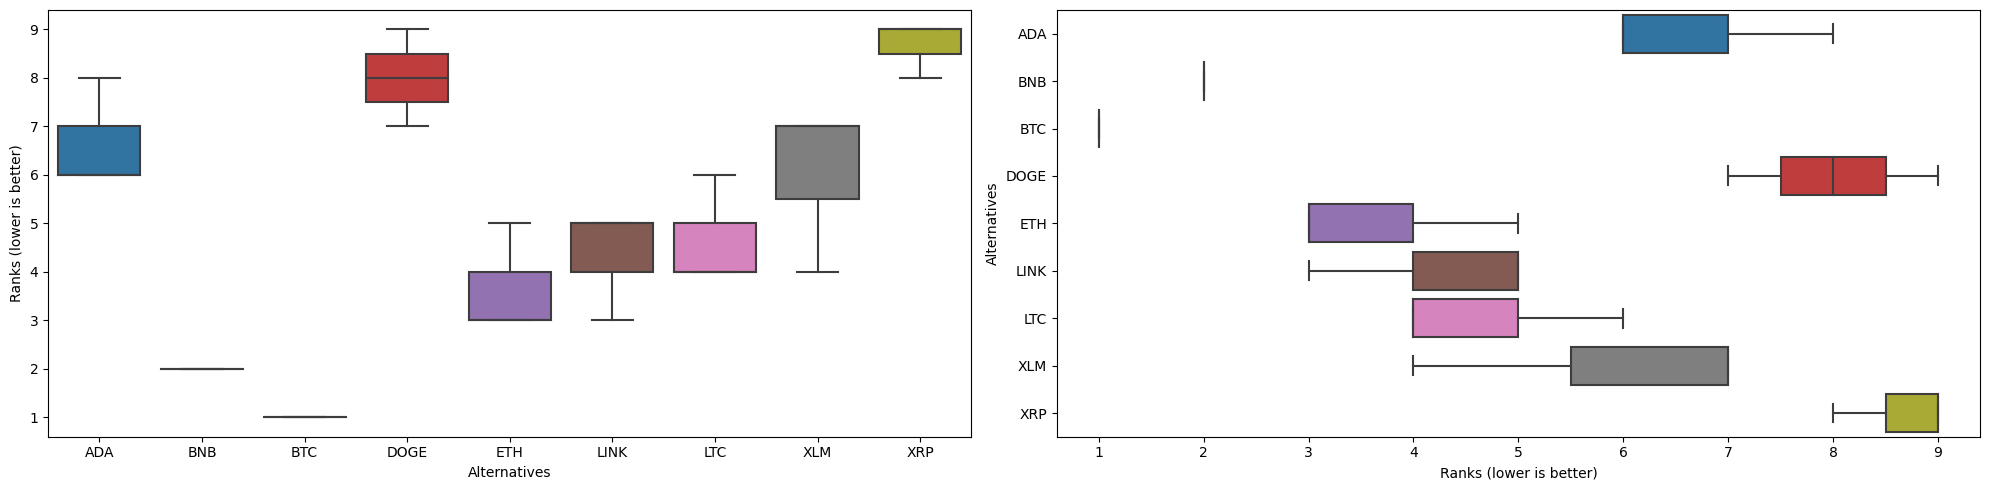

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.box(ax=axs[0]) 
rcmp.plot.box(ax=axs[1], orient="h") 

fig.tight_layout();

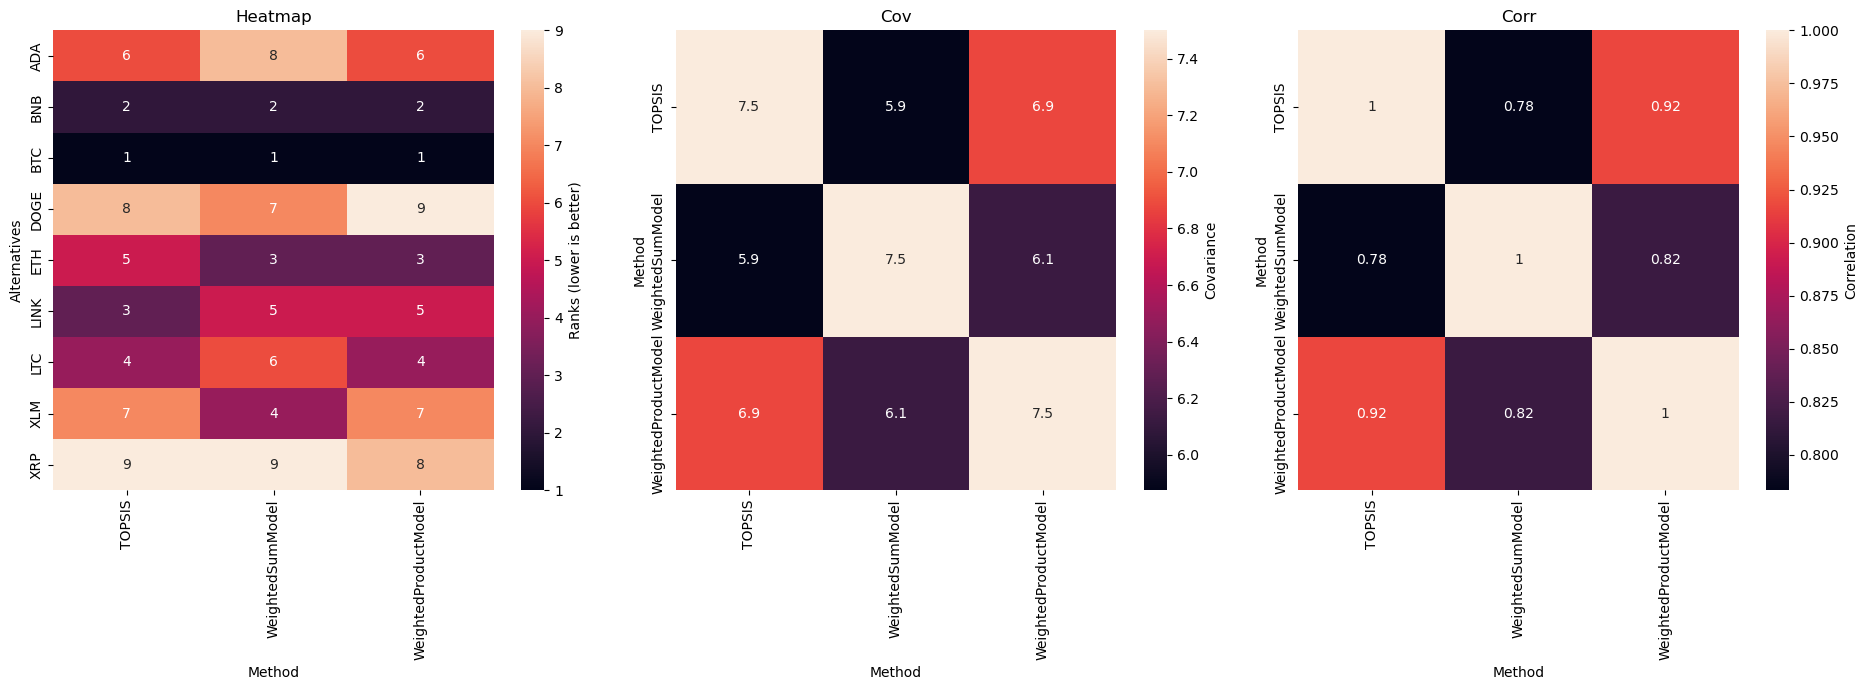

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

for kind, ax in zip(["heatmap", "cov", "corr"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())


fig.tight_layout()

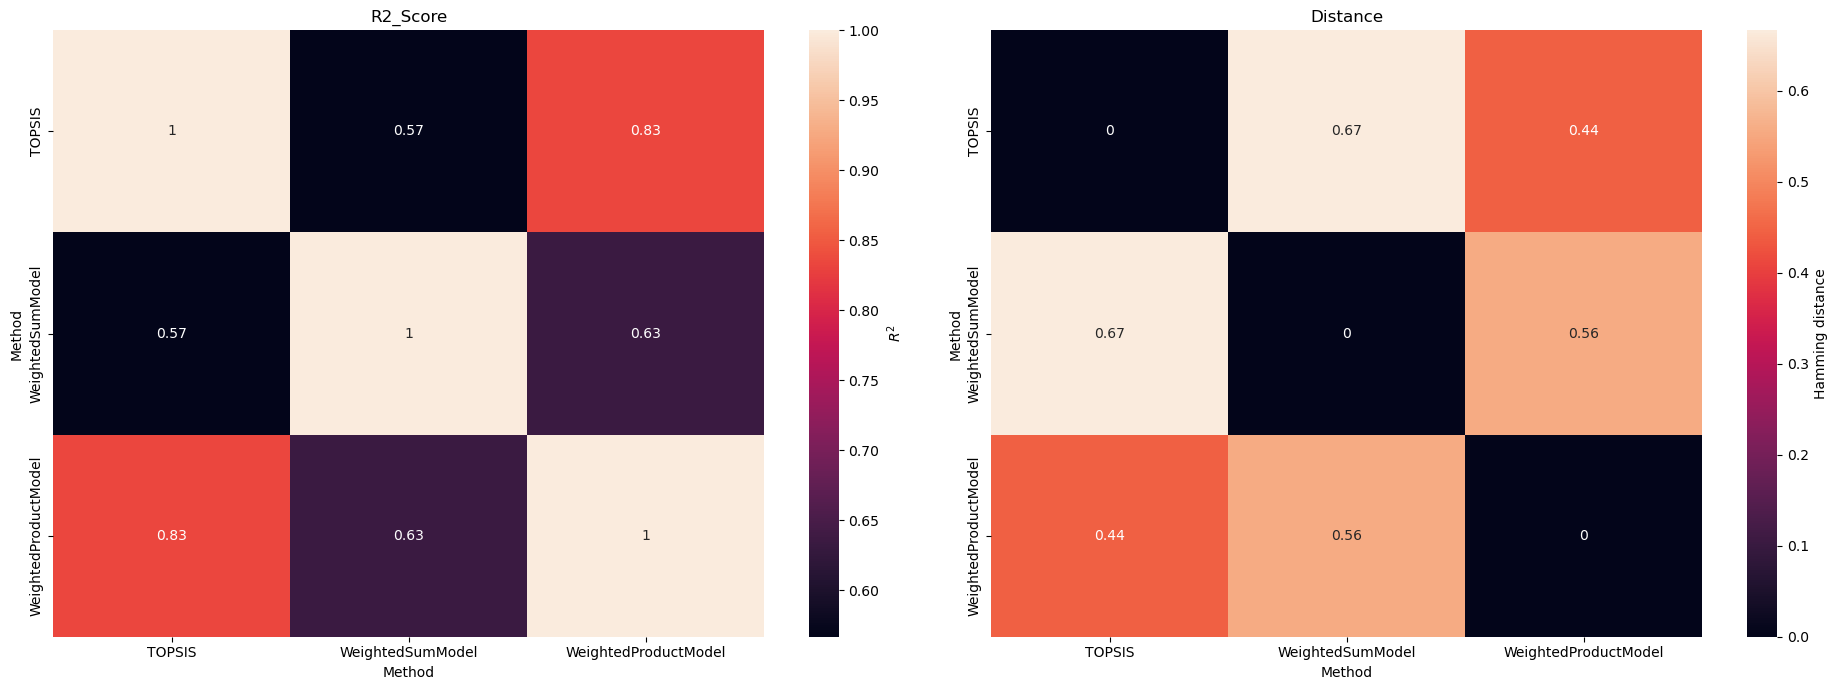

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))

for kind, ax in zip(["r2_score", "distance"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())

fig.tight_layout()